<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Предварительный-обзор-данных" data-toc-modified-id="Предварительный-обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предварительный обзор данных</a></span></li><li><span><a href="#Синтетические-признаки" data-toc-modified-id="Синтетические-признаки-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Синтетические признаки</a></span></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Обработка пропусков</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии,-построенная-на-всех-данных" data-toc-modified-id="Модель-линейной-регрессии,-построенная-на-всех-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель линейной регрессии, построенная на всех данных</a></span></li><li><span><a href="#Модель-линейной-регрессии,-построенная-на-числовых-переменных" data-toc-modified-id="Модель-линейной-регрессии,-построенная-на-числовых-переменных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель линейной регрессии, построенная на числовых переменных</a></span></li></ul></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ результатов</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pyspark
import pyspark.sql.functions as F
import seaborn as sns

from IPython.display import HTML, display
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.sql import SparkSession, Window as W
from pyspark.sql.types import *
from scipy.stats import mannwhitneyu
from tqdm import tqdm

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator as OneHotEncoder

SEED = 12345

display(HTML('<style>.container { width:90% !important; }</style>'))

### Предварительный обзор данных

In [2]:
spark = (SparkSession.builder.master('local')
         .appName('EDA California Housing').getOrCreate())

df = spark.read.load('/datasets/housing.csv', format='csv', sep=',',
                     inferSchema=True, header='true')

In [3]:
df.sample(fraction=7e-4, withReplacement=False, seed=SEED).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -119.73|   36.77|              24.0|     4410.0|         939.0|    2362.0|     862.0|       2.9406|           73000.0|         INLAND|
|  -118.49|   34.26|              25.0|     8389.0|        1872.0|    4483.0|    1747.0|       3.5497|          261300.0|      <1H OCEAN|
|  -118.29|   34.05|              31.0|     2818.0|        1252.0|    4126.0|    1200.0|        2.053|          229200.0|      <1H OCEAN|
|  -118.37|   33.99|              36.0|     3228.0|         543.0|    1305.0|     520.0|       5.1695|          397000.0|      <1H OCEAN|
|   -117.9|   34.53|              

In [4]:
spark.createDataFrame(df.dtypes, ('column', 'type')).show()

+------------------+------+
|            column|  type|
+------------------+------+
|         longitude|double|
|          latitude|double|
|housing_median_age|double|
|       total_rooms|double|
|    total_bedrooms|double|
|        population|double|
|        households|double|
|     median_income|double|
|median_house_value|double|
|   ocean_proximity|string|
+------------------+------+



In [5]:
df.filter(F.col('total_rooms') <= F.col('total_bedrooms')).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -117.79|   35.21|               4.0|        2.0|           2.0|       6.0|       2.0|        2.375|          137500.0|         INLAND|
|  -118.44|   34.28|              46.0|       11.0|          11.0|      24.0|      13.0|        2.875|          162500.0|      <1H OCEAN|
|  -121.04|   37.67|              16.0|       19.0|          19.0|     166.0|       9.0|        0.536|          162500.0|         INLAND|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [6]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [7]:
df_length = df.count()
df_length

20640

In [8]:
df_length == df.dropDuplicates().count()

True

### Синтетические признаки

In [9]:
df = df.withColumn('rooms_per_household',
                   F.col('total_rooms') / F.col('households'))
df = df.withColumn('population_in_household',
                    F.col('population') / F.col('households'))
df = df.withColumn('bedroom_index',
                    F.col('total_bedrooms') / F.col('total_rooms'))

### Обработка пропусков

In [10]:
columns = df.columns

print('Количество пропусков:\n')
for column in columns:
    missing_values = df.filter(F.col(column).isNull()).count()
    print(f' -  {column} {missing_values}')

Количество пропусков:

 -  longitude 0
 -  latitude 0
 -  housing_median_age 0
 -  total_rooms 0
 -  total_bedrooms 207
 -  population 0
 -  households 0
 -  median_income 0
 -  median_house_value 0
 -  ocean_proximity 0
 -  rooms_per_household 0
 -  population_in_household 0
 -  bedroom_index 207


In [11]:
(
    df.groupby('ocean_proximity')
    .agg(F.expr('percentile_approx(bedroom_index, 0.5)'))
    .show()
)

+---------------+-------------------------------------+
|ocean_proximity|percentile_approx(bedroom_index, 0.5)|
+---------------+-------------------------------------+
|         ISLAND|                  0.26506024096385544|
|     NEAR OCEAN|                  0.20709335507541785|
|       NEAR BAY|                  0.20674157303370785|
|      <1H OCEAN|                  0.20668316831683167|
|         INLAND|                  0.19826589595375724|
+---------------+-------------------------------------+



In [12]:
df = df.withColumn(
    'bedroom_index',
    F.when(
        F.col('bedroom_index').isNull(),
        F.expr('percentile_approx(bedroom_index, 0.5)')
        .over(W.partitionBy('ocean_proximity'))
    ).otherwise(F.col('bedroom_index'))
)

In [13]:
df = df.withColumn('is_null', F.col('total_bedrooms').isNull())

In [14]:
cols = ['ocean_proximity', 'total_rooms', 'bedroom_index', 'total_bedrooms']
(
    df.filter(F.col('is_null')).select(cols)
    .sample(fraction=.1, withReplacement=False, seed=SEED).show()
)

+---------------+-----------+-------------------+--------------+
|ocean_proximity|total_rooms|      bedroom_index|total_bedrooms|
+---------------+-----------+-------------------+--------------+
|     NEAR OCEAN|     2790.0|0.20709335507541785|          null|
|     NEAR OCEAN|     1321.0|0.20709335507541785|          null|
|     NEAR OCEAN|      771.0|0.20709335507541785|          null|
|       NEAR BAY|     1256.0|0.20674157303370785|          null|
|       NEAR BAY|      992.0|0.20674157303370785|          null|
|       NEAR BAY|      746.0|0.20674157303370785|          null|
|       NEAR BAY|     2947.0|0.20674157303370785|          null|
|      <1H OCEAN|     8879.0|0.20668316831683167|          null|
|      <1H OCEAN|      880.0|0.20668316831683167|          null|
|      <1H OCEAN|      991.0|0.20668316831683167|          null|
|      <1H OCEAN|    10267.0|0.20668316831683167|          null|
|      <1H OCEAN|     5736.0|0.20668316831683167|          null|
|      <1H OCEAN|     130

In [15]:
df = df.withColumn(
    'total_bedrooms',
    F.when(
        F.col('total_bedrooms').isNull(),
        F.round(F.col('total_rooms') * F.col('bedroom_index'), 0)
    ).otherwise(F.col('total_bedrooms'))
)

In [16]:
(
    df.filter(F.col('is_null')).select(cols)
    .sample(fraction=.1, withReplacement=False, seed=SEED).show()
)

+---------------+-----------+-------------------+--------------+
|ocean_proximity|total_rooms|      bedroom_index|total_bedrooms|
+---------------+-----------+-------------------+--------------+
|     NEAR OCEAN|     2790.0|0.20709335507541785|         578.0|
|     NEAR OCEAN|     1321.0|0.20709335507541785|         274.0|
|     NEAR OCEAN|      771.0|0.20709335507541785|         160.0|
|       NEAR BAY|     1256.0|0.20674157303370785|         260.0|
|       NEAR BAY|      992.0|0.20674157303370785|         205.0|
|       NEAR BAY|      746.0|0.20674157303370785|         154.0|
|       NEAR BAY|     2947.0|0.20674157303370785|         609.0|
|      <1H OCEAN|     8879.0|0.20668316831683167|        1835.0|
|      <1H OCEAN|      880.0|0.20668316831683167|         182.0|
|      <1H OCEAN|      991.0|0.20668316831683167|         205.0|
|      <1H OCEAN|    10267.0|0.20668316831683167|        2122.0|
|      <1H OCEAN|     5736.0|0.20668316831683167|        1186.0|
|      <1H OCEAN|     130

In [17]:
df = df.drop('is_null')

In [18]:
columns = df.columns

print('Количество пропусков:\n')
for column in columns:
    missing_values = df.filter(F.col(column).isNull()).count()
    print(f' -  {column} {missing_values}')

Количество пропусков:

 -  longitude 0
 -  latitude 0
 -  housing_median_age 0
 -  total_rooms 0


 -  total_bedrooms 0
 -  population 0
 -  households 0
 -  median_income 0
 -  median_house_value 0
 -  ocean_proximity 0
 -  rooms_per_household 0
 -  population_in_household 0


 -  bedroom_index 0


**Вывод:**  
- набор данных состоит из 20640 объектов, содержит 9 числовых и 1 категориальную переменную;  
- данные содержат выбросы и пропуски;  
- явные дубликаты отсутствуют;  
- добавлены синтетические признаки: `rooms_per_household`, `population_in_household` и `bedroom_index`;  
- пропуски в `bedroom_index` заполнены медианным значением в зависимости от удалённости от океана;  
- пропуски в столбце `total_bedrooms` заполнены произведением `total_rooms` и `bedroom_index`.

## Обучение моделей

In [19]:
train_data, test_data = df.randomSplit([.8,.2], seed=SEED)
print(train_data.count(), test_data.count())

16489 4151


In [20]:
categorical_col = 'ocean_proximity'
indexer = StringIndexer(inputCols=[categorical_col], 
                        outputCols=[f'{categorical_col}_idx'],
                        handleInvalid='keep')

encoder = OneHotEncoder(inputCols=[f'{categorical_col}_idx'],
                        outputCols=[f'{categorical_col}_ohe'])

(
    test_data.select(categorical_col)
    .subtract(train_data.select(categorical_col))
    .collect()
)

[]

In [21]:
numerical_cols = [col for col in df.columns
                  if not col.startswith(categorical_col)
                  and col != 'median_house_value']
numerical_cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'population_in_household',
 'bedroom_index']

In [22]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                      outputCol='numerical_features')

In [23]:
scaler = StandardScaler(inputCol='numerical_features',
                        outputCol='numerical_features_scaled',
                        withMean=True)

all_features = ['ocean_proximity_ohe','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features')

In [24]:
stages = [indexer, encoder, numerical_assembler, scaler, final_assembler]


def get_pipeline(features='features', stages=stages):
    lr = LinearRegression(labelCol='median_house_value', featuresCol=features,
                          regParam=1, solver='l-bfgs')
    stages.append(lr)
    return Pipeline(stages=stages)

### Модель линейной регрессии, построенная на всех данных

In [25]:
%%time
pipeline = get_pipeline()
model = pipeline.fit(train_data)

23/10/27 15:01:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/10/27 15:01:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


CPU times: user 280 ms, sys: 78.9 ms, total: 359 ms
Wall time: 1min 37s


In [26]:
predictions = model.transform(test_data)

In [27]:
evaluator = RegressionEvaluator(labelCol='median_house_value',
                                predictionCol='prediction')

In [28]:
metrics = ['mae', 'rmse', 'r2']
result = [evaluator.evaluate(predictions, {evaluator.metricName: metric})
          for metric in metrics]

### Модель линейной регрессии, построенная на числовых переменных

In [29]:
%%time
pipeline_num = get_pipeline('numerical_features_scaled',
                            [numerical_assembler, scaler])
model_num = pipeline_num.fit(train_data)

predictions_num = model_num.transform(test_data)

CPU times: user 168 ms, sys: 38.4 ms, total: 206 ms
Wall time: 59 s


In [30]:
result_num = [evaluator.evaluate(predictions_num,
                                 {evaluator.metricName: metric})
              for metric in metrics]

**Вывод**:<br>
построены две модели линейной регрессии на разных наборах данных:  
- используя все данные из файла;  
- используя только числовые переменные, исключив категориальные.

## Анализ результатов

In [31]:
def get_ax(stats, lbl='Все признаки', color='tab:blue',
           line_color='black', alpha=.4):
    lower, upper, mean, values = stats
    name_stat = {
        'среднее': mean, '2.5%-квантиль': lower, '97.5%-квантиль': upper
    }
    lines = ['-', '--']
    ax = sns.histplot(values, edgecolor='white', label=lbl,
                      alpha=alpha, color=color, kde=True)
    for name, stat in name_stat.items():
        ax.axvline(x=stat, c=line_color, ls=lines[int(stat != mean)],
                   lw=1, label=f'{name}: {stat:,.0f}'.replace(',', ' '))
    return ax


def get_histograms(stats, stats_num):
    plt.figure(figsize=(15, 5))
    ax1 = get_ax(stats)
    ax2 = get_ax(stats_num, 'Числовые признаки',
                 color='sandybrown', line_color='r')
    plt.ylabel('Количество')
    plt.xlabel('Средняя абсолютная ошибка')
    plt.title(
        'Распределения возможных значений средней абсолютной ошибки'
    )
    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid(True, alpha=.3)

In [32]:
metric_scores = {metric: (score, score_num) for metric, score, score_num
                 in zip(metrics, result, result_num)}
results = pd.DataFrame(data=metric_scores,
                       index=['Все данные', 'Только числовые переменные'])
results[['mae', 'rmse']] = results[['mae', 'rmse']].round(0).astype('int')
results['r2'] = results['r2'].round(3)
results

,mae,rmse,r2
Все данные,48116,65635,0.669
Только числовые переменные,49012,66363,0.662


In [33]:
predictions = predictions.withColumn(
    'prediction_target_abs_diff',
    F.abs(F.col('prediction') - F.col('median_house_value'))
)
abs_differences = predictions.select('prediction_target_abs_diff').toPandas()

predictions_num = predictions_num.withColumn(
    'prediction_target_abs_diff',
    F.abs(F.col('prediction') - F.col('median_house_value'))
)
abs_differences_num = \
    predictions_num.select('prediction_target_abs_diff').toPandas()

In [34]:
def get_statistics(vals):
    vals = pd.Series(vals)
    lower = vals.quantile(0.025)
    upper = vals.quantile(0.975)
    mean = vals.mean()
    return lower, upper, mean, vals


def bootstrap(values, values_num):
    mae_values = []
    mae_values_num = []
    state = np.random.RandomState(SEED)

    for _ in tqdm(range(10000)):
        subsample = values.sample(frac=1, random_state=state,
                                  replace=True)
        subsample_num = values_num.sample(frac=1, random_state=state,
                                          replace=True)
        mae_values.append(subsample.mean())
        mae_values_num.append(subsample_num.mean())

    return (get_statistics(mae_values),
            get_statistics(mae_values_num))

In [35]:
statistics, statistics_num = bootstrap(
    abs_differences['prediction_target_abs_diff'],
    abs_differences_num['prediction_target_abs_diff']
)

100%|██████████| 10000/10000 [00:06<00:00, 1585.02it/s]


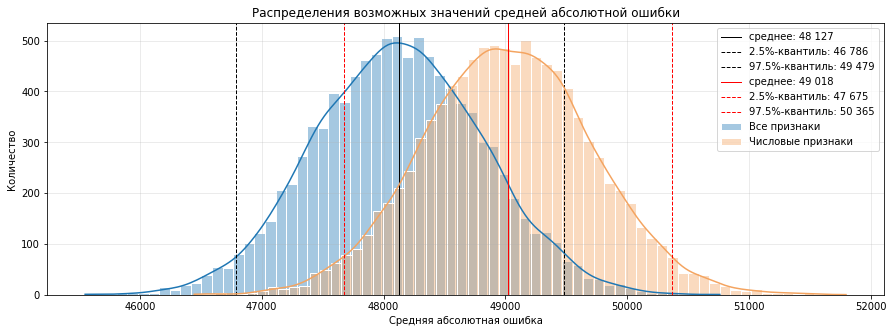

In [36]:
get_histograms(statistics, statistics_num)

**H0**: распределение признака `prediction_target_abs_diff` в первой выборке соответствует распределению во второй выборке.     
**H1**: распределение признака `prediction_target_abs_diff` в первой выборке не соответствует распределению во второй выборке.

In [37]:
stat, p = mannwhitneyu(abs_differences['prediction_target_abs_diff'],
                       abs_differences_num['prediction_target_abs_diff'])
print(f'Statistics={stat}, p={p:.3f}')
alpha = 0.05
if p < alpha:
    print('Достаточно оснований отклонить нулевую гипотезу')
else:
    print('Нет достаточных оснований отклонить нулевую гипотезу')

Statistics=8468209.0, p=0.178
Нет достаточных оснований отклонить нулевую гипотезу


In [38]:
print('Отрицательные значения (все признаки)')
display(
    predictions.filter(F.col('prediction') < 0)
    .select(['median_house_value', 'prediction'])
    .toPandas()
)
print('\nОтрицательные значения (числовые признаки)')
(
    predictions_num.filter(F.col('prediction') < 0)
    .select(['median_house_value', 'prediction'])
    .toPandas()
)

Отрицательные значения (все признаки)


,median_house_value,prediction
0,153300.0,-7984.297140
1,65200.0,-2107.499267
2,67500.0,-30579.709295
3,115400.0,-64305.866390
4,116300.0,-33962.426893
5,56100.0,-31648.725334
6,60800.0,-7424.147230
7,86800.0,-28154.252925



Отрицательные значения (числовые признаки)


,median_house_value,prediction
0,350000.0,-745.086551
1,153300.0,-16929.674953
2,58600.0,-10374.186857
3,44000.0,-36614.423538
4,88900.0,-6614.327789
5,34200.0,-28966.299309
6,92800.0,-1204.342173
7,65200.0,-11985.874841
8,57500.0,-24713.730282
9,48100.0,-15208.829629


В обеих выборках присутствует незначительное количество отрицательных значений.  
В предсказаниях модели, построенной на всех признаках, содержится меньшее количество отрицательных значений.

**Вывод**: модель, построенная на всех признаках, показала лучшие результаты. Тем не менее оснований утверждать, что она будет лучше справляться с поставленной задачей недостаточно.

In [39]:
spark.stop()

## Общий вывод

**Описание данных:**  
`longitude` — долгота;  
`latitude` — широта;  
`housing_median_age` — медианный возраст жителей жилого массива;  
`total_rooms` — общее количество комнат в домах жилого массива;  
`total_bedrooms` — общее количество спален в домах жилого массива;  
`population` — количество человек, которые проживают в жилом массиве;  
`households` — количество домовладений в жилом массиве;  
`median_income` — медианный доход жителей жилого массива;   
`ocean_proximity` — близость к океану.  

**Целевой признак:**  
`median_house_value` — медианная стоимость дома в жилом массиве.   

**Ход исследования**:  
- в загруженном наборе данных обнаружены пропуски и выбросы;  
- добавлены синтетические признаки;  
- пропуски в `bedroom_index` заполнены медианным значением в зависимости от удалённости от океана;  
- пропуски в столбце `total_bedrooms` заполнены произведением `total_rooms` и `bedroom_index`;  
- категориальный признак преобразован техникой One hot encoding;  
- числовые признаки масштабированы с помощью `StandardScaler`;  
- исследованы две модели линейной регрессии: первая построена на всех признаках, вторая – только на числовых;  
- лучшие результаты показала модель, построенная на всех признаках:  
    - `mae` = 48116;  
    - `rmse` = 65635;  
    - `r2` = 0.669.